## Forecasting a Function

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
signal_length = 100
signal_repeats = 3
predict_ahead = 1
noise_strength = 0.03
total_series_length = signal_length * signal_repeats

Input: sinus signal $\sin(x_t)$

Target: same signal but predict\_ahead steps ($\delta$) shifted (predict to future) $ \sin(x_{t+\delta}) $

In [3]:
dims = 1
def generateData(signal_length, predict_ahead, 
                 signal_repeats, batch_size, noise_strength):
    total_series_length = signal_length * signal_repeats
    time = np.linspace(
        0, np.pi*2*signal_repeats, 
        total_series_length + predict_ahead, dtype=np.float32
    )
    time = time.reshape((1, -1, 1))  
    
    # include shift for batches
    time = np.repeat(time, batch_size, 0)
    time += np.random.random(batch_size)[:, None, None] * 10
    y = np.sin(time)
    input_ = y[:, :total_series_length].copy()
    if noise_strength > 0:
        input_ += np.random.normal(size=(input_.shape)) * noise_strength # add some noise to the input
    target = y[:, predict_ahead:]
    return torch.tensor(input_) , torch.tensor(target)

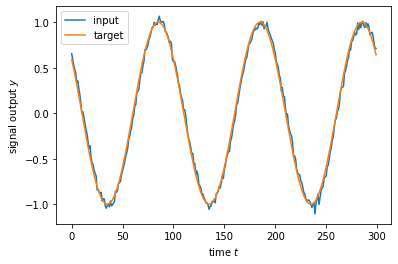

In [4]:
x, y = generateData(
    signal_length, predict_ahead, signal_repeats, 1, noise_strength
)
x_i, y_i = x[0, :, 0], y[0, :, 0]
f, ax = plt.subplots(1)
ax.plot(x_i, label="input")
ax.plot(y_i, label="target")
ax.set_xlabel("time $t$")
ax.set_ylabel("signal output $y$")
ax.legend()

# Recurrent Neural Network (RNN)
**fully-connected-layer** is defined as:

$\mathbf{o} \leftarrow \sigma \left( W \cdot \mathbf{x} + \mathbf{b} \right)$
* activation function $\sigma$ (e.g. ReLU, tanH)
* weight matrix $W \in \mathbb{R}^{m \times d}$
* number of neurons $m$ and dimensionality $d$ of input $\mathbf{x} = (x_1 , \ldots , x_d)$
* bias vector $\mathbf{b}$
* output $\mathbf{o}$

**RNN-layer** is defined as:

$ \mathbf{o} \leftarrow \mathbf{h}_t \leftarrow \sigma \bigl( W \cdot \mathbf{x}_t +$ 
<font color=red> $ U \cdot \mathbf{h}_{t-1} $</font>
$ + \mathbf{b} \bigr) $

* the output $\mathbf{o}$ is also the hidden state $\mathbf{h}$ at time $t$
* input are time steps of the series: $\left( \ldots, \mathbf{x}_{t-1}, \mathbf{x}_{t},  \mathbf{x}_{t+1}, \ldots \right)$
* previous hidden state $h_{t-1}$ or the "memory" has its own weight matrix $U \in \mathbb{R}^{m \times m}$


## Simple Recurrent Networks (SRN)
 $\renewcommand{\hat}[1]{\widehat{#1}}$
**Elman network**: 
    
$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $




## **Long-Short-Term Memory (LSTM) Layer**

|||
|-------------|---------------------------------------------------------------------|
|hidden state | $\mathbf{h}_t \leftarrow \mathbf{o}_t \circ \sigma_h(\mathbf{c}_t)$ |
|cell state   | $\mathbf{c}_t \leftarrow \mathbf{f}_t \circ \mathbf{c}_{t-1} + \mathbf{i}_t \circ \mathbf{j}_t $ |
|output gate  | $\mathbf{o}_t \leftarrow \sigma_o(W_o \cdot \mathbf{x}_t + U_o \cdot \mathbf{h}_{t-1} + \mathbf{b}_o)$ |
|forget gate  | $\mathbf{f}_t \leftarrow \sigma_f(W_f \cdot \mathbf{x}_t + U_f \cdot \mathbf{h}_{t-1} + \mathbf{b}_f)$ |
|input gate   | $\mathbf{i}_t \leftarrow \sigma_i(W_i \cdot \mathbf{x}_t + U_i \cdot \mathbf{h}_{t-1} + \mathbf{b}_i)$|
|modulation gate| $\mathbf{j}_t \leftarrow \sigma_j(W_j \cdot \mathbf{x}_t + U_j \cdot \mathbf{h}_{t-1} + \mathbf{b}_j)$ |

- $W \in \mathbb{R}^{m \times d}$ weight matrices for input vector $\mathbf{x}_t$
- $U \in \mathbb{R}^{m \times m}$ weight matrices for hidden state vector $\mathbf{h}_{t-1}$
- activation functions $\sigma_h$ and $\sigma_j$ are usually $tanh$
- activation functions $\sigma_f$, $\sigma_i$, and $\sigma_o$ are usually $sigmoid$
- element-wise multiplication is $\circ$
    * important for gating (all values between usually between -1 and 1 (tanh) or 0 and 1 (sigmoid)
- cell state $\mathbf{c}$ : stores contextual and longer term information
- hidden state $\mathbf{h}$ : stores immediately necessary information and **is given to next layer**


## Creating an LSTM model

In [5]:
# use the hidden state (True) by activating learning for U_h
rnn_mode = True
# learn a better initial hidden state representation (True) than zero init
learn_h0 = True

# number of weight update iterations
n_iterations = 250

# number of neurons m in the hidden layer
num_neurons = 8
batch_size = 5
lr = 0.01

device = "cpu"

In [6]:
# first, define our model and initialize the learnable weights and biases (parameters):
class LSTM(nn.Module):
    def __init__(self, dims, hidden_dims, learn_h0=False, learn_c0=False,
                 activation_h=nn.Tanh,
                 activation_o=nn.Sigmoid, activation_f=nn.Tanh, 
                 activation_i=nn.Sigmoid, activation_j=nn.Sigmoid, 
                 rnn_mode=True):
        super().__init__()
        # it is fine to hard code these 
        self.activation_h = activation_h()
        self.activation_o = activation_o()
        self.activation_f = activation_f()
        self.activation_i = activation_i()
        self.activation_j = activation_j()
        
        # parameters of the (recurrent) hidden layer
        self.W_o = nn.Parameter(torch.randn(dims, hidden_dims) * .1)
        self.b_o = nn.Parameter(torch.zeros(1, hidden_dims))
        self.W_f = nn.Parameter(torch.randn(dims, hidden_dims) * .1)
        self.b_f = nn.Parameter(torch.zeros(1, hidden_dims))
        self.W_i = nn.Parameter(torch.randn(dims, hidden_dims) * .1)
        self.b_i = nn.Parameter(torch.zeros(1, hidden_dims))
        self.W_j = nn.Parameter(torch.randn(dims, hidden_dims) * .1)
        self.b_j = nn.Parameter(torch.zeros(1, hidden_dims))
        
        
        self.U_o = nn.Parameter(
            torch.randn(hidden_dims, hidden_dims) * .1
        )
        self.U_f = nn.Parameter(
            torch.randn(hidden_dims, hidden_dims) * .1
        )
        self.U_i = nn.Parameter(
            torch.randn(hidden_dims, hidden_dims) * .1
        )
        self.U_j = nn.Parameter(
            torch.randn(hidden_dims, hidden_dims) * .1
        )
        
        if not rnn_mode:
            self.U_o.zero_(); self.U_f.zero_(); self.U_i.zero_(); self.U_j.zero_()
            self.U_o.requires_grad = False
            self.U_f.requires_grad = False
            self.U_i.requires_grad = False
            self.U_j.requires_grad = False

        # initial hidden state
        self.h_0 = nn.Parameter(
            torch.zeros(1, hidden_dims),
            requires_grad=learn_h0 # only train this if enabled
        )        
        
        # initial cell state
        self.c_0 = nn.Parameter(
            torch.zeros(1, hidden_dims),
            requires_grad=learn_c0 # only train this if enabled
        )
        
        # output layer (fully connected)
        self.W_y = nn.Parameter(torch.randn(hidden_dims, dims) * .1)
        self.b_y = nn.Parameter(torch.zeros(1, dims))
                
    def step(self, x_t, h, c):
        #  forward pass for a single time step
        # hint: a more clever implementation could combine all these and select the different parts later
        j = self.activation_j(
            torch.matmul(x_t, self.W_j) + torch.matmul(h, self.U_j) + self.b_j
        )
        i = self.activation_i(
            torch.matmul(x_t, self.W_i) + torch.matmul(h, self.U_i) + self.b_i
        )
        f = self.activation_f(
            torch.matmul(x_t, self.W_f) + torch.matmul(h, self.U_f) + self.b_f
        )        
        o = self.activation_o(
            torch.matmul(x_t, self.W_o) + torch.matmul(h, self.U_o) + self.b_o
        )
        
        
        c = f * c + i * j
        
        h = o * self.activation_h(c)

        return h, c # returning new hidden and cell state

    def iterate_series(self, x, h, c):
        # apply rnn to each time step and give an output (many-to-many task)
        batch_size, n_steps, dimensions = x.shape
        
        # can use cell states list here but only the last cell is required
        hidden_states = []
        # iterate over time axis (1)
        for t in range(n_steps):
            # give previous hidden state and input from the current time step
            h, c = self.step(x[:, t], h, c)
            hidden_states.append(h)
        hidden_states = torch.stack(hidden_states, 1)
        
        # fully connected output
        y_hat = hidden_states.reshape(batch_size * n_steps, -1) # flatten steps and batch size (bs * )
        y_hat = torch.matmul(y_hat, self.W_y) + self.b_y
        y_hat = y_hat.reshape(batch_size, n_steps, -1) # regains structure
        return y_hat, hidden_states[:, -1], c
    
    def forward(self, x, h, c):
        # x: b, t, d
        batch_size = x.shape[0] 
        if h is None:
            h = self.h_0.repeat_interleave(batch_size, 0)
        if c is None:
            c = self.c_0.repeat_interleave(batch_size, 0)
        y_hat, h, c = self.iterate_series(x, h, c)
        return y_hat, h, c
    
    def auto_regression(self, x_0, h, c, steps):
        # one-to-many task (steps = \delta')
        x_prev = x_0
        y_hat = []
        # iterate over time axis (1)
        for t in range(steps):
            # give previous hidden state and input from the current time step
            h, c = self.step(x_prev, h, c)
            # here we need to apply the output layer on each step individually
            x_prev = torch.matmul(h, self.W_y) + self.b_y
            
            y_hat.append(x_prev)
        y_hat = torch.stack(y_hat, 1)
        return y_hat, h, c
    
    def many_to_one(self, x, h, c):
        # not required
        # returns the last prediction and the hidden state
        y_hat, h, c = self(x, h, c)
        return y_hat[:, -1], h, c # only return the last prediction
        
    def many_to_many_async(self, x, h, c, steps):
        # not required
        # combines many-to-one and one-to-many
        x_0, h, c = self.many_to_one(x, h, c)
        return self.auto_regression(x_0, h, c, steps)

for backpropagation we use Adam, but we could use any optimizer from tf.keras.optimizer (or write our own)

In [7]:
rnn = LSTM(
    dims, num_neurons, 
    learn_h0=learn_h0, 
    rnn_mode=rnn_mode
)
rnn.to(device)

# standard optimizer SGD or AdaGrad would also work
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

## Training the model

In [8]:
# just a helper function to see the progress
def replot(input_series, predictions_series, batchY, iteration, loss):
    f, ax = plt.subplots(2, 2, figsize=(15, 7.5))
    steps = range(total_series_length)
    # show prediction
    ax[1, 1].plot(steps, batchY, color="blue", label="target $y$")
    ax[1, 1].plot(steps, predictions_series, color="red", label="prediction $\haty$")
    ax[1, 1].plot(steps, input_series, color="green", label="input $x$")
    ax[1, 1].text(0, 1, f"Iteration: {iteration} Loss: {loss[-1]}", )
    ax[1, 1].set_ylabel("value")
    ax[1, 1].set_xlabel("steps")
    ax[1, 1].set_title("current prediction")
    ax[1, 1].legend(loc='upper right')
    
    # show prediction (zoomed in)
    ax[1, 0].plot(
        steps[-signal_length:], batchY[-signal_length:], 
        color="blue", label="target $y$"
    )
    ax[1, 0].plot(
        steps[-signal_length:], predictions_series[-signal_length:], 
        color="red", label="prediction $\haty$"
    )
    ax[1, 0].plot(
        steps[-signal_length:], input_series[-signal_length:], 
        color="green", label="input $x$"
    )
    ax[1, 0].set_ylabel("value")
    ax[1, 0].set_xlabel("steps")
    ax[1, 0].set_title("current prediction (zoomed in)")
    ax[1, 0].legend(loc='upper right')

    # show errors (zoomed in)
    ax[0, 0].plot(
        steps[-signal_length:], 
        batchY[-signal_length:] - predictions_series[-signal_length:], 
        color="blue", label="errors $y$"
    )
    ax[0, 0].set_ylabel("residual")
    ax[0, 0].set_xlabel("steps")
    ax[0, 0].set_title("errors (zoomed in)")
    ax[0, 0].legend(loc='upper right')
    
    # show training loss
    ax[0, 1].plot(range(iteration), loss, color="blue", label="loss")
    ax[0, 1].set_title("training loss")
    ax[0, 1].legend(loc='upper right')
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_ylabel("loss")
    ax[0, 1].set_xlabel("iteration")
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)

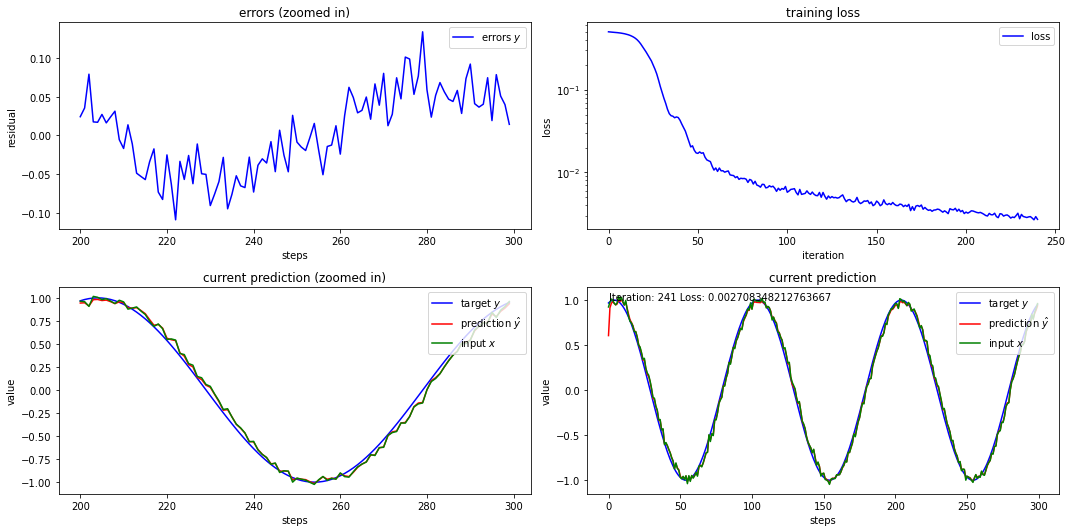

In [9]:
rnn.train()
iteration = 0
# how often we plot the prediction
log_iter = 10
iter_loss = []

# train for a set number of iterations
for iteration in range(n_iterations):
    # generates a long time series / normally loaded from dataset (e.g. stocks, weather)
    x, y = generateData(
        signal_length, predict_ahead, signal_repeats, batch_size, noise_strength
    )
    x, y = x.to(device), y.to(device)
    h = c = None
    # reset gradients
    optimizer.zero_grad()
    
    # get predictions (forward pass)
    y_hat, h, c = rnn(x, h, c)
           
    # calculate mean squared error
    loss = torch.mean((y_hat - y)**2)        
    # backprop
    loss.backward()
    
    # finally we are adapting the weights with the saved gradient information
    optimizer.step()
    # log loss
    iter_loss.append(loss.item())
    
    # plot model predictions during training
    if iteration % log_iter == 0:
        replot(x[0].cpu(), y_hat[0].detach().cpu(), 
               y[0].cpu(), iteration + 1, iter_loss)

# Free Running RNN (Generating) or Auto-Regressive Prediction
to make continous predictions 

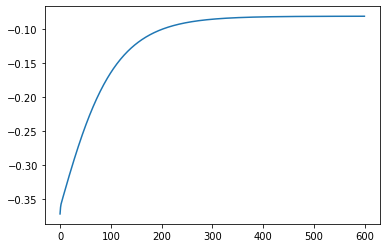

In [10]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)
    c_ar = rnn.c_0.repeat_interleave(batch_s, 0)

    # initial (single) value for x
    x_0 = torch.rand(batch_s, 1) * 2 - 1 # between -1 and 1
    x_0 = x_0.to(device)
    
    # any length possible here
    length = total_series_length * 2
    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar, c_ar = rnn.auto_regression(x_0, h_ar, c_ar, length)

    f, ax = plt.subplots(1)
    ax.plot(y_hat[0, :, 0].cpu())


# Continuation of a signal (many-to-many)
can be used to forecast many steps ahead

the red and blue line should align, the error should be around 0.007

MSE: 0.22990071773529053


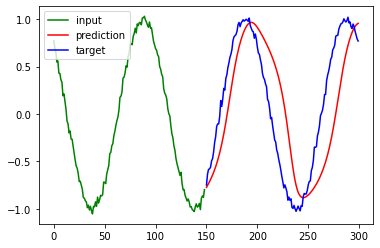

In [31]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)
    c_ar = rnn.c_0.repeat_interleave(batch_s, 0)

    # initial values for x
    x_full, _ = generateData(
        signal_length, predict_ahead, signal_repeats, batch_s, noise_strength
    )
    x_full = x_full.to(device)
    split_point = total_series_length//2
    
    x = x_full[:, :split_point - predict_ahead]
    y = x_full[:, split_point:]
    
    # any length possible here
    length = y.size(1)
    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar, c_ar = rnn.many_to_many_async(x, h_ar, c_ar, length)

    # show forecast
    f, ax = plt.subplots(1)
    ax.plot(
        range(split_point - predict_ahead), x[0, :, 0].cpu(), 
        c="green", label="input")
    ax.plot(
        range(split_point, total_series_length), 
        y_hat[0, :, 0].cpu(), c="red", label="prediction"
    )
    ax.plot(
        range(split_point, total_series_length), 
        y[0, :, 0].cpu(), c="blue", label="target"
    )
    plt.legend()
    
    # print error:
    print(f"MSE: {((y_hat - y)**2).mean()}")


# many-to-one test
the scatter points should nearly align and the error should be around 0.0002

MSE: 0.0003506806096993387


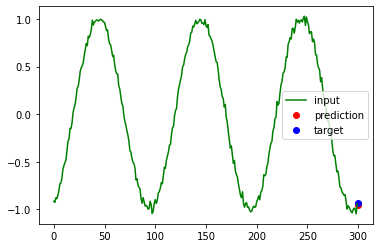

In [32]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)
    c_ar = rnn.c_0.repeat_interleave(batch_s, 0)

    # initial values for x
    x, y = generateData(
        signal_length, predict_ahead, signal_repeats, batch_s, noise_strength
    )
    y = y[:, -1] # change the task to many-to-one
    x = x.to(device)
    y = y.to(device)

    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar, c_ar = rnn.many_to_one(x, h_ar, c_ar)

    # show forecast
    f, ax = plt.subplots(1)
    ax.plot(
        range(total_series_length), x[0, :, 0].cpu(), 
        c="green", label="input")
    ax.scatter(
        total_series_length, 
        y_hat[0, 0].cpu(), c="red", label="prediction"
    )
    ax.scatter(
        total_series_length, 
        y[0, 0].cpu(), c="blue", label="target"
    )
    plt.legend()
    
    # print error:
    print(f"MSE: {((y_hat - y)**2).mean()}")
